# Extra Credit Assignment - Quanwei Gu(quanwei2) & Ziqi Li(ziqili3)

In this notebook file, we built another adversarial attack: the **PGD Attack**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms,models
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# load resnet50 as the pretrained model
model = models.resnet50(pretrained=True).to(device)
model.eval()

# load and normalize data
transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder('./imagenette2-320/val', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

cuda:0


# **The Projected Gradient Descent Attack (PGD)**

We also implemented PGD attack which is one upgraded BIM attack category. 

PGD attempts to find the perturbation that maximizes the loss of a model on a particular input while keeping the size of the perturbation smaller than a specified amount referred to as epsilon.

The constraint is `L_∞` norm of the perturbation. After adding such a constraint,the content of the adversarial image will has little difference to the unperturbed sample. In other words, the adversarial example will be imperceptibly different to us.

Our PGD attack consists of initializing the search for an adversarial example at **a random point** within the allowed norm ball, then running several iterations of attacks to find an adversarial example. 

PGD attack, as a more powerful and reliable attack than BIM, is more complete than BIM because of the implementation of L∞ norm constraint and random initialization method.

**References:**

< *Know your enemy
How you can create and defend against adversarial attacks*  >

https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3

< *Towards Deep Learning Models Resistant to Adversarial
Attacks* >

https://arxiv.org/abs/1706.06083

In [ ]:
# PGD Attack function

def PGD_attack(image, epsilon,target, origin):
    #constraint 
    eps = 8.0 / 225.0

    # get prediction
    output = model(image).to(device)[:, indices]
    # calculate loss and backward
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward(retain_graph=True)
    
    # gather gradients
    data_grad = image.grad.data

    # calculate perturbed_image  
    sign_data_grad = data_grad.sign() 
    perturbed_image = image + epsilon*sign_data_grad

    # constraint the image to land within L∞ norm of the perturbation
    adv = perturbed_image - image
    adv = torch.clamp(adv, -eps, eps)
    
    # clip image
    finalimage = image + adv
    finalimage = torch.clamp(finalimage, 0, 1)
    
    return finalimage

In [ ]:
#create random startpoint
def ran(image,shape):

  # bound from our origin image
  eps = 8.0 / 225.0 

  # create a new image within the bound of eps from original image
  new = np.random.uniform(-eps, eps, shape)
  newimage = torch.tensor(image.detach().cpu().numpy() + new)

  # clip the image
  newimage_cliped = torch.clamp(newimage, 0, 1) 
  return newimage_cliped


In [ ]:
#main test function
def test_PGD( model, device, test_loader, epsilon ):
    #set up basic vars
    #10 indices
    indices = [0, 217,482, 491,497,566, 569, 571,574,701]
    # number of loops
    step = 40 
    #count for acc
    correct = 0
    # store examples
    adv_examples = []
    #eps
    eps = 8.0 / 225.0 
    # number of restart times for PGD
    randomstart = 5

    #loop through all images
    for i, (image, target) in enumerate(test_loader):
        shape = image.shape
        image, target = image.to(device), target.to(device)
        image.requires_grad = True

        #make initial predictions(store start points)
        output = model(image).to(device)[:, indices]  
        _, init_pred = torch.max(output,1) 

        #loop through PGD 
        for starttime in range(randomstart):
          newimage = image.detach().clone()
          newimage.requires_grad = True

          #if we failed 1st time, use a random point instead of origin image
          if starttime >= 1:
            newimage.data = ran(newimage,shape).float().to(device)
            
          #attack! attack "step" times before stop
          for attack in range(step):
            newimage.data = PGD_attack(newimage, epsilon,target,image)
            
          #final prediction 
          output = model(newimage).to(device)[:, indices]    
        
          _, final_pred = torch.max(output,1) 

          #if success, stop
          if final_pred.item() != target.item():
            break

        #count acc and save example images
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = newimage.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = newimage.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

Run PGD Attack on the pretrained model

In [ ]:
epsilons = [0.0005]
accuracies = []
examples = []

# Run test for epsilon = 0.0005
for eps in epsilons:
    print("current eps is: ", eps)
    acc, ex = test_PGD(model, device, dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

current eps is:  0.0005
Epsilon: 0.0005	Test Accuracy = 45 / 3925 = 0.011464968152866241


As we can see here, the PGD attack significantly affected the prediction of the pretrained classifier.

Plot some adversarial samples

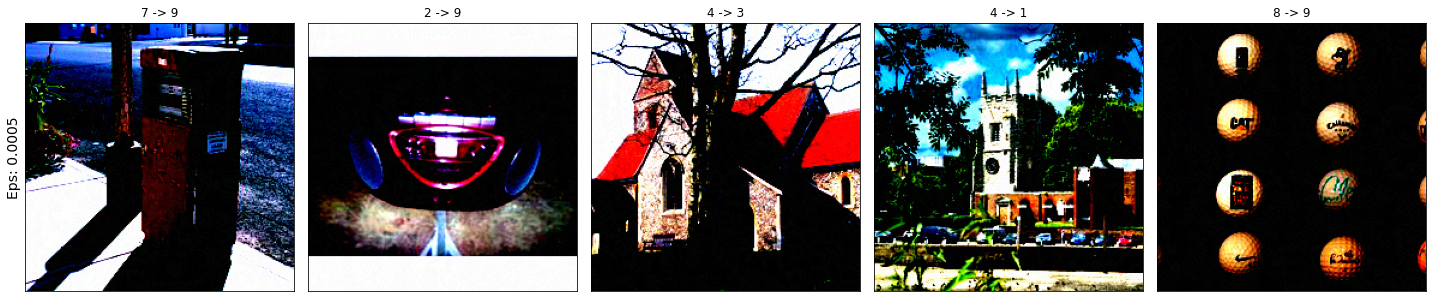

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(20,20))
for i in range(len(epsilons)):
    # if i==1:
      # print(examples[i])
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])

        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        # print(ex.shape)
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.transpose((1,2,0)))
plt.tight_layout()
plt.show()